In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import OLSInfluence
import itertools
import pyreadr

# Problem 1

In [186]:
df = pd.read_csv('surgical_unit.txt', sep='\s+', names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y', "y' = lny"])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y,y' = lny
0,6.7,62,81,2.59,50,0,1,0,695,6.544
1,5.1,59,66,1.70,39,0,0,0,403,5.999
2,7.4,57,83,2.16,55,0,0,0,710,6.565
3,6.5,73,41,2.01,48,0,0,0,349,5.854
4,7.8,65,115,4.30,45,0,0,1,2343,7.759


In [187]:
X = df[['x1', 'x2', 'x3', 'x4']]
X = sm.add_constant(X)
Y = df['y']
Y_scaled = df["y' = lny"]
model = sm.OLS(Y, X).fit()
print(model.summary())
MSE_full = model.mse_resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     27.40
Date:                Sun, 11 May 2025   Prob (F-statistic):           5.70e-12
Time:                        17:23:39   Log-Likelihood:                -367.59
No. Observations:                  54   AIC:                             745.2
Df Residuals:                      49   BIC:                             755.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1279.2416    243.808     -5.247      0.0

In [188]:
model_scaled = sm.OLS(Y_scaled, X).fit()
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:               y' = lny   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     38.62
Date:                Sun, 11 May 2025   Prob (F-statistic):           1.39e-14
Time:                        17:23:39   Log-Likelihood:                0.67208
No. Observations:                  54   AIC:                             8.656
Df Residuals:                      49   BIC:                             18.60
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8519      0.266     14.467      0.0

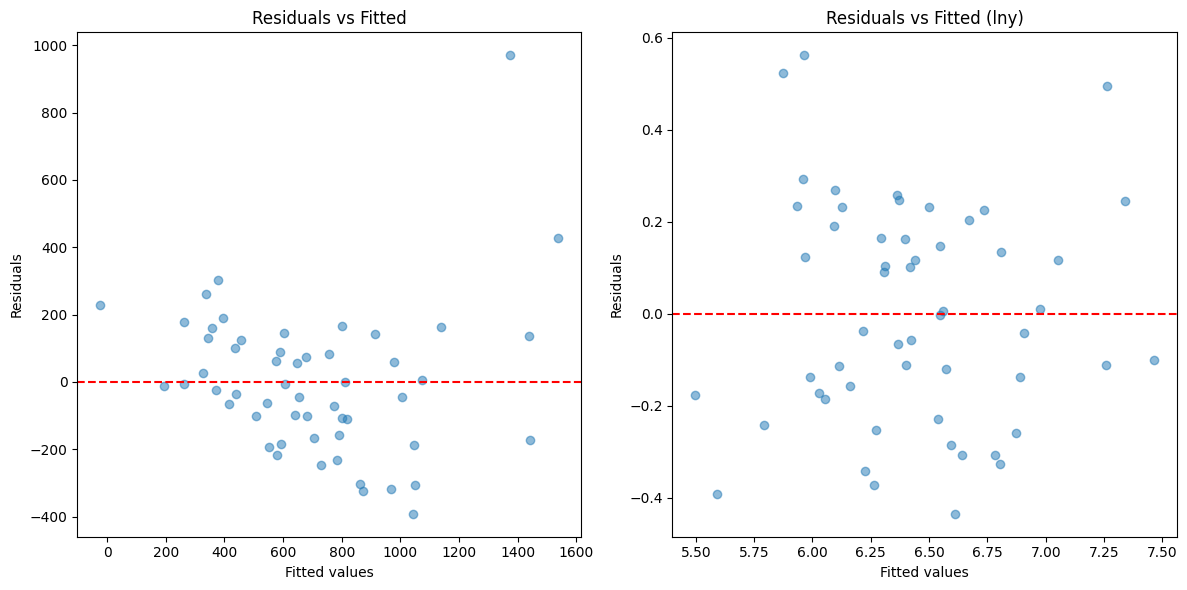

In [189]:
#residual plots
y_residuals = df['y'] - model.fittedvalues
fitted = model.fittedvalues
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fitted, y_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.subplot(1, 2, 2)

lny_residuals = df["y' = lny"] - model_scaled.fittedvalues
plt.scatter(model_scaled.fittedvalues, lny_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (lny)')
plt.tight_layout()
plt.show()

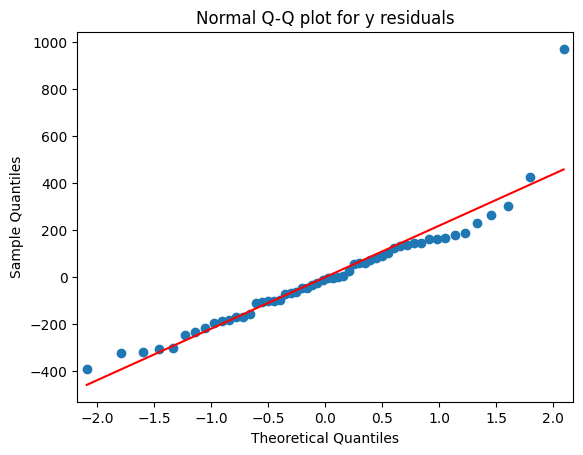

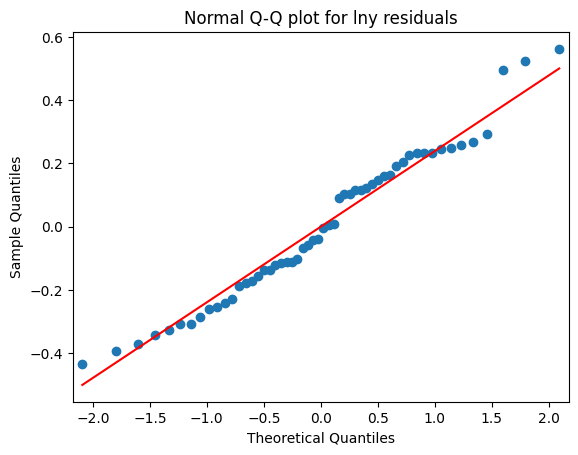

In [190]:
#Normal plot for y
sm.qqplot(y_residuals, line='s')
plt.title('Normal Q-Q plot for y residuals')
plt.show()
#Normal plot for lny
sm.qqplot(lny_residuals, line='s')
plt.title('Normal Q-Q plot for lny residuals')
plt.show()

The plot of residuals against fitted values; also the normal probability plot of residuals for the original and transformed data show that the distribution of the error terms is more nearly normal.

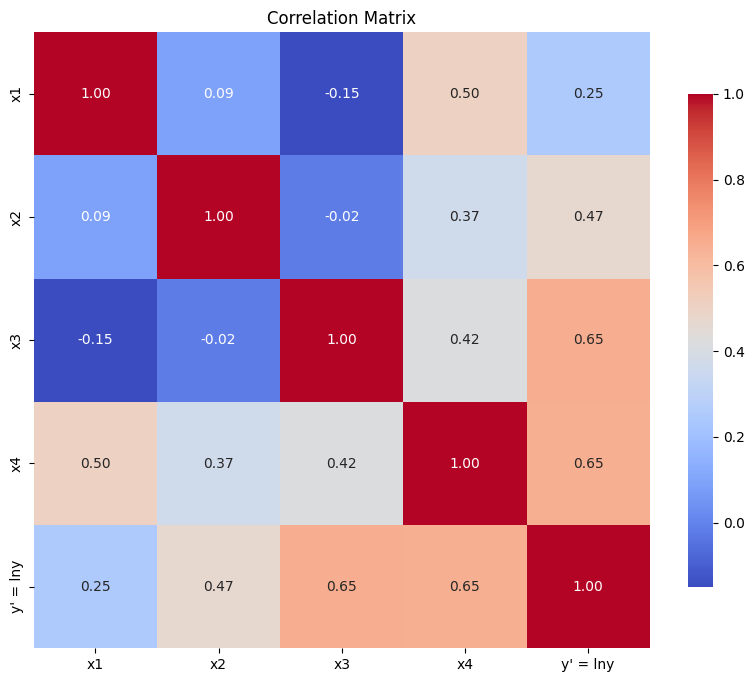

In [191]:
df.drop(columns=['x5', 'x6', 'x7', 'x8', 'y'], inplace=True)
#correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

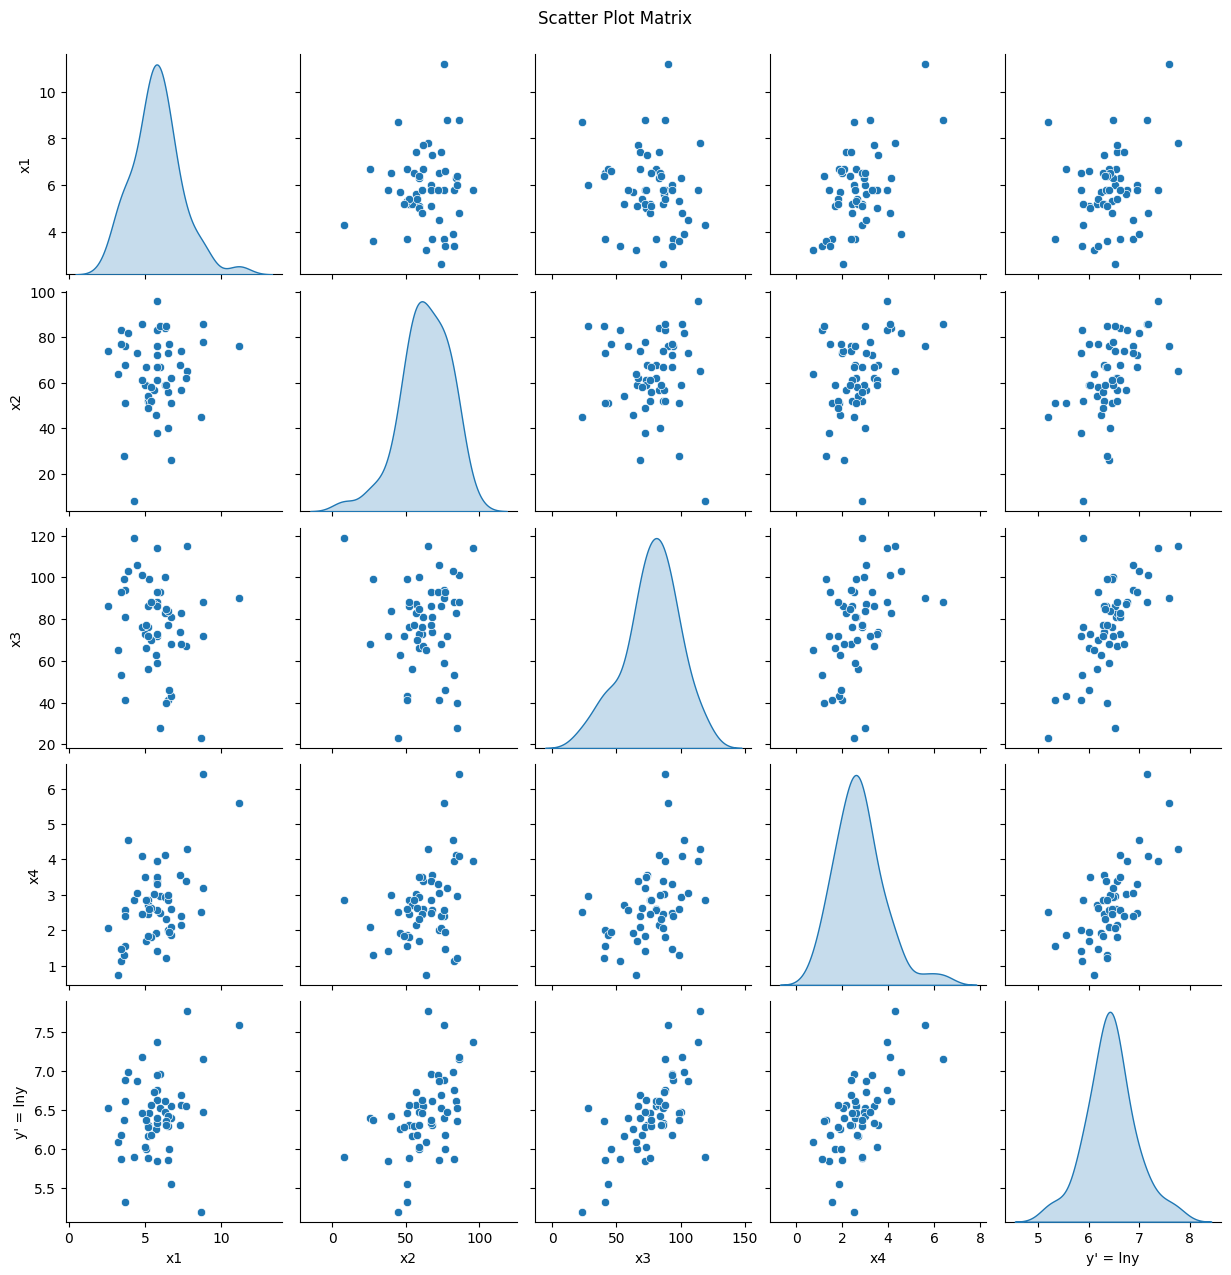

In [192]:
#scatter plot matrix
sns.pairplot(df, diag_kind='kde', markers='o')
plt.suptitle('Scatter Plot Matrix', y=1.02)
plt.show()

Correlation matrix and scatter plots indicate that each of the predictor variables is linearly associated with lny , with X3 and X4 showing the highest degrees of association and X1 the lowest.   
X4 has moderately high pairwise correlations with X1, X2, and X3.

In [193]:
p = df.shape[1] 
p

5

In [194]:
# Initialize a list to store results
results = []
predictors = df.columns[:-1]  # Exclude the last two columns (y and y' = lny)
Y = df["y' = lny"]  # Response variable

# Iterate over all possible combinations of predictors
for p in range(1, p + 2):  # p ranges from 1 (intercept only) to k + 1 (all predictors)
    for combo in itertools.combinations(predictors, p - 1):
        if p == 0:
            # Intercept-only model
            X = pd.DataFrame({'const': np.ones(len(Y))})
        else:
            X = df[list(combo)]
            X = sm.add_constant(X)  # Add intercept
        
        # Fit the model
        model = sm.OLS(Y, X).fit()
        n = len(Y)
        SSE_p = model.ssr
        R2_p = model.rsquared
        R2_adj_p = model.rsquared_adj
        
        # Total sum of squares for the full model (SST)
        SST = ((Y - Y.mean()) ** 2).sum()
        
        # Mallows' Cp
        MSE_full = model.mse_resid  # MSE for the full model (assuming this is the largest model)
        Cp_p = (SSE_p / MSE_full) + 2 * p - n
        
        # AIC
        AIC_p = model.aic
        
        # SBC (BIC)
        SBC_p = model.bic
        
        # PRESS statistic
        influence = OLSInfluence(model)
        press_p = ((influence.resid_press) ** 2).sum()
        
        # Store results
        results.append({
            'Variables in Model': ', '.join(combo) if combo else 'None',
            'p': p,
            'SSE_p': SSE_p,
            'R2_p': R2_p,
            'R2_adj_p': R2_adj_p,
            'Cp': Cp_p,
            'AIC_p': AIC_p,
            'SBC_p': SBC_p,
            'PRESS_p': press_p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by p (number of predictors) for better readability
results_df = results_df.sort_values(by=['p', 'Variables in Model']).reset_index(drop=True)

# Display the results
print(results_df)

   Variables in Model  p      SSE_p      R2_p  R2_adj_p   Cp      AIC_p  \
0                None  1  12.807725  0.000000  0.000000  1.0  77.542844   
1                  x1  2  12.031469  0.060608  0.042543  2.0  76.166607   
2                  x2  2   9.979182  0.220847  0.205863  2.0  66.067284   
3                  x3  2   7.331575  0.427566  0.416558  2.0  49.418500   
4                  x4  2   7.408731  0.421542  0.410418  2.0  49.983821   
5              x1, x2  3   9.442671  0.262736  0.233824  3.0  65.083125   
6              x1, x3  3   5.780964  0.548635  0.530934  3.0  38.587027   
7              x1, x4  3   7.299052  0.430106  0.407757  3.0  51.178427   
8              x2, x3  3   4.312491  0.663290  0.650086  3.0  22.762071   
9              x2, x4  3   6.622011  0.482967  0.462692  3.0  45.921778   
10             x3, x4  3   5.129702  0.599484  0.583777  3.0  32.132795   
11         x1, x2, x3  4   3.108539  0.757292  0.742729  4.0   7.084483   
12         x1, x2, x4  4 

In [195]:
list_of_subsets = []
for p in range(1, p + 2):  # p ranges from 1 (intercept only) to k + 1 (all predictors)
    for combo in itertools.combinations(predictors, p - 1):
        list_of_subsets.append(combo)
table = pd.DataFrame(zip(list_of_subsets), columns=['Subset'])

In [196]:
#p
list_of_betas = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        betas = model.params.values
        list_of_betas.append(len(betas))
table['p'] = list_of_betas

In [197]:
#SSE_p
list_of_sse = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        SSE_p = model.ssr
        list_of_sse.append(SSE_p)
table['SSE_p'] = list_of_sse

In [198]:
#R2_p
list_of_r2 = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        R2_p = model.rsquared
        list_of_r2.append(R2_p)
table['R2_p'] = list_of_r2

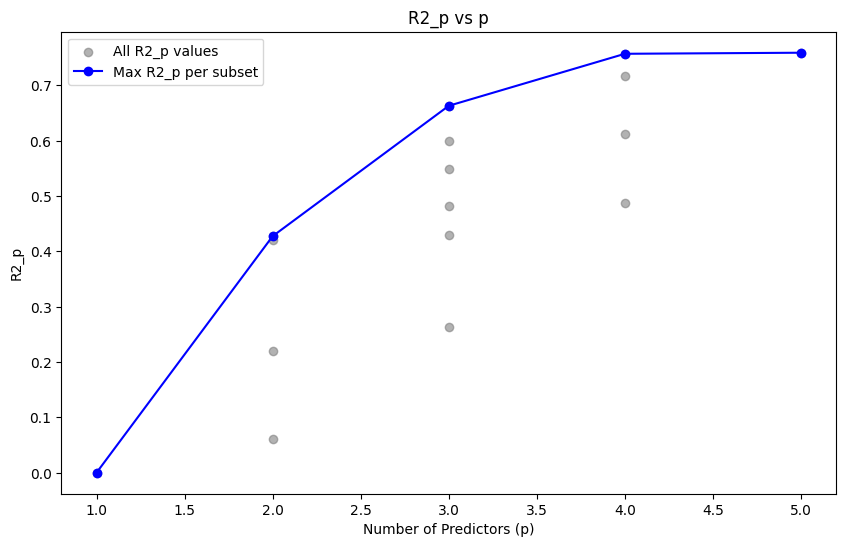

In [199]:
plt.figure(figsize=(10, 6))
max_R2_per_p = table.loc[table.groupby('p')['R2_p'].idxmax()]

# Plot all R2_p values
plt.scatter(table['p'], table['R2_p'], color='gray', alpha=0.6, label='All R2_p values')

# Plot and connect max R2_p values
plt.plot(max_R2_per_p['p'], max_R2_per_p['R2_p'], marker='o', linestyle='-', color='b', label='Max R2_p per subset')

plt.title('R2_p vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('R2_p')
plt.legend();

In [200]:
#R2_adj_p
list_of_r2_adj = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        R2_adj_p = model.rsquared_adj
        list_of_r2_adj.append(R2_adj_p)
table['R2_adj_p'] = list_of_r2_adj

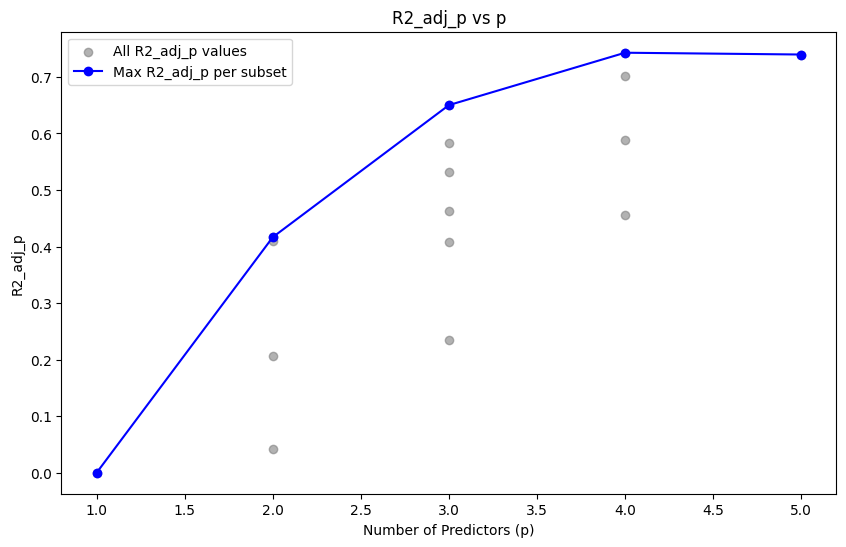

In [201]:
#plot R2_adj_p
plt.figure(figsize=(10, 6))
max_R2_adj_per_p = table.loc[table.groupby('p')['R2_adj_p'].idxmax()]

# Plot all R2_adj_p values
plt.scatter(table['p'], table['R2_adj_p'], color='gray', alpha=0.6, label='All R2_adj_p values')

# Plot and connect max R2_adj_p values
plt.plot(max_R2_adj_per_p['p'], max_R2_adj_per_p['R2_adj_p'], marker='o', linestyle='-', color='b', label='Max R2_adj_p per subset')
plt.title('R2_adj_p vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('R2_adj_p')
plt.legend();

In [202]:
#Cp
list_of_cp = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        SSE_p = model.ssr
        n = len(Y)
        MSE_full = model.mse_resid  # MSE for the full model (assuming this is the largest model)
        Cp_p = (SSE_p / MSE_full) + 2 * (p+1) - n
        list_of_cp.append(Cp_p)
table['Cp'] = list_of_cp

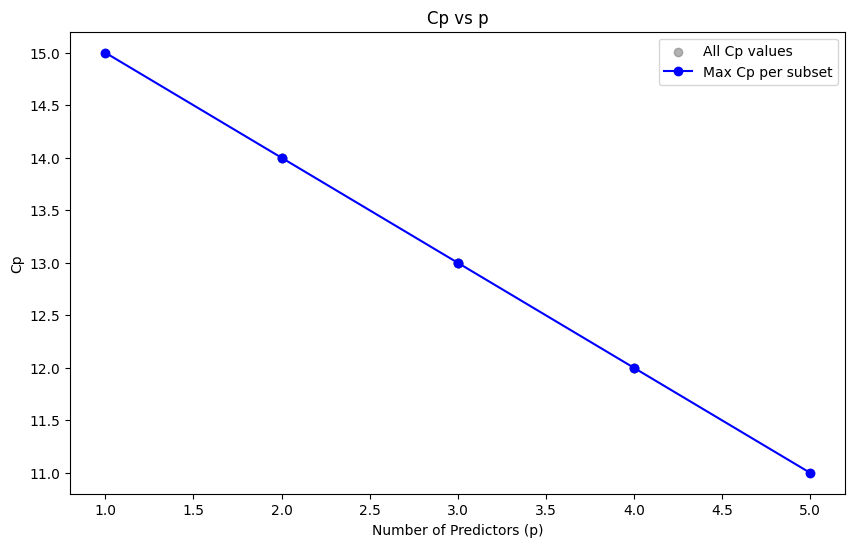

In [203]:
#plot Cp
plt.figure(figsize=(10, 6))
max_Cp_per_p = table.loc[table.groupby('p')['Cp'].idxmax()]

# Plot all Cp values
plt.scatter(table['p'], table['Cp'], color='gray', alpha=0.6, label='All Cp values')

# Plot and connect max Cp values
plt.plot(max_Cp_per_p['p'], max_Cp_per_p['Cp'], marker='o', linestyle='-', color='b', label='Max Cp per subset')
plt.title('Cp vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('Cp')
plt.legend();

In [204]:
#AIC_p
list_of_aic = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        SSE_p = model.ssr
        n = len(Y)
        AIC_p = n * np.log(SSE_p) - n * np.log(n) + 2 * (p)
        # AIC_p = model.aic  # Alternatively, you can use the built-in AIC from the model
        list_of_aic.append(AIC_p)
table['AIC_p'] = list_of_aic

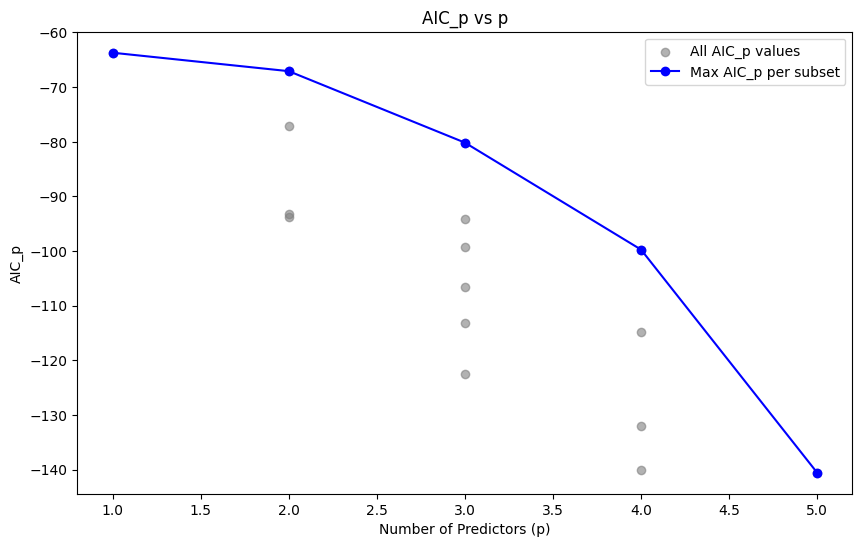

In [205]:
#plot AIC_p vs p
plt.figure(figsize=(10, 6))
max_AIC_per_p = table.loc[table.groupby('p')['AIC_p'].idxmax()]

# Plot all AIC_p values
plt.scatter(table['p'], table['AIC_p'], color='gray', alpha=0.6, label='All AIC_p values')

# Plot and connect max AIC_p values
plt.plot(max_AIC_per_p['p'], max_AIC_per_p['AIC_p'], marker='o', linestyle='-', color='b', label='Max AIC_p per subset')
plt.title('AIC_p vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('AIC_p')
plt.legend();

In [206]:
#SBC_p
list_of_sbc = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        SSE_p = model.ssr
        n = len(Y)
        SBC_p = model.bic
        list_of_sbc.append(SBC_p)
table['SBC_p'] = list_of_sbc

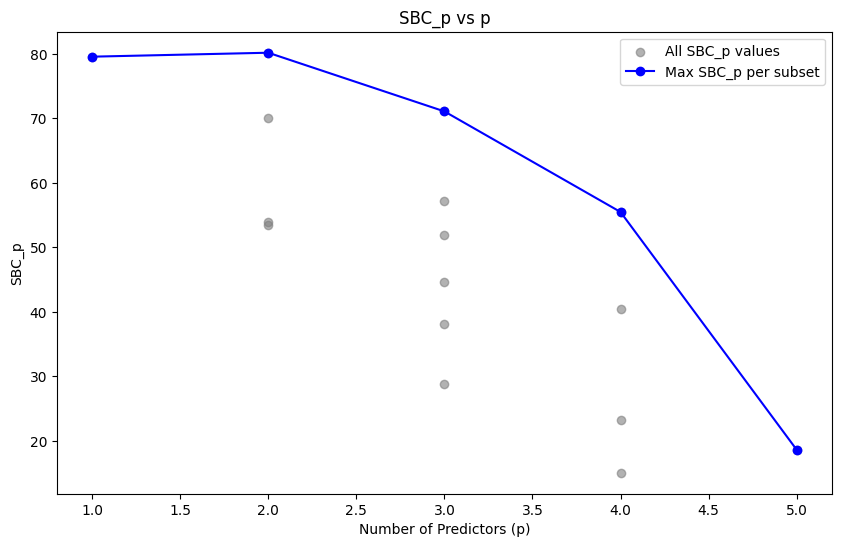

In [207]:
#plot SBC_p
plt.figure(figsize=(10, 6))
max_SBC_per_p = table.loc[table.groupby('p')['SBC_p'].idxmax()]

# Plot all SBC_p values
plt.scatter(table['p'], table['SBC_p'], color='gray', alpha=0.6, label='All SBC_p values')

# Plot and connect max SBC_p values
plt.plot(max_SBC_per_p['p'], max_SBC_per_p['SBC_p'], marker='o', linestyle='-', color='b', label='Max SBC_p per subset')
plt.title('SBC_p vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('SBC_p')
plt.legend();

In [208]:
#PRESS_p
list_of_press = []
for i in list_of_subsets:
    if isinstance(i, tuple):  # Ensure i is a tuple of column names
        X = df[list(i)]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(Y, X).fit()
        influence = OLSInfluence(model)
        press_p = ((influence.resid_press) ** 2).sum()
        list_of_press.append(press_p)
table['PRESS_p'] = list_of_press

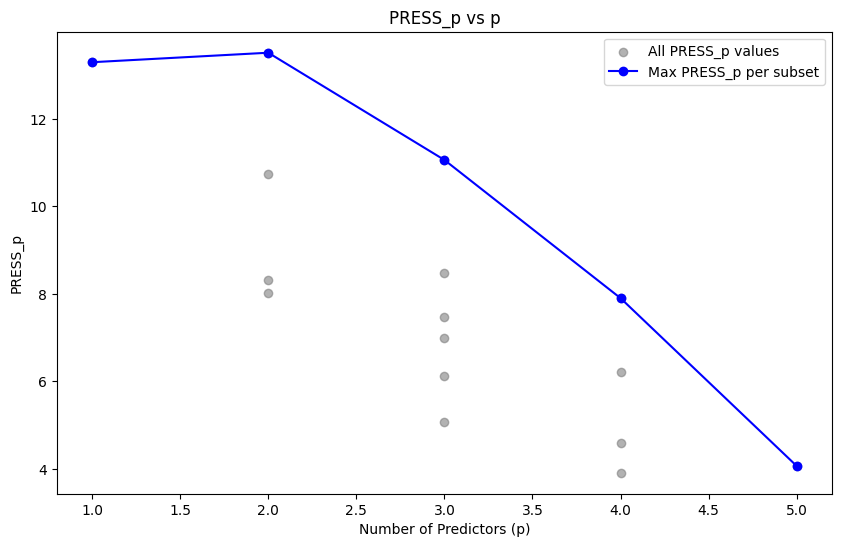

In [209]:
#plot PRESS_p
plt.figure(figsize=(10, 6))
max_PRESS_per_p = table.loc[table.groupby('p')['PRESS_p'].idxmax()]

# Plot all PRESS_p values
plt.scatter(table['p'], table['PRESS_p'], color='gray', alpha=0.6, label='All PRESS_p values')

# Plot and connect max PRESS_p values
plt.plot(max_PRESS_per_p['p'], max_PRESS_per_p['PRESS_p'], marker='o', linestyle='-', color='b', label='Max PRESS_p per subset')
plt.title('PRESS_p vs p')
plt.xlabel('Number of Predictors (p)')
plt.ylabel('PRESS_p')
plt.legend();

In [210]:
table

,Subset,p,SSE_p,R2_p,R2_adj_p,Cp,AIC_p,SBC_p,PRESS_p
0,(),1,12.807725,0.000000,0.000000,15.0,-63.702517,79.531828,13.295595
1,"(x1,)",2,12.031469,0.060608,0.042543,14.0,-67.078755,80.144575,13.512470
2,"(x2,)",2,9.979182,0.220847,0.205863,14.0,-77.178077,70.045252,10.743872
3,"(x3,)",2,7.331575,0.427566,0.416558,14.0,-93.826861,53.396468,8.326716
4,"(x4,)",2,7.408731,0.421542,0.410418,14.0,-93.261541,53.961789,8.024956
5,"(x1, x2)",3,9.442671,0.262736,0.233824,13.0,-80.162236,71.050078,11.062050
6,"(x1, x3)",3,5.780964,0.548635,0.530934,13.0,-106.658335,44.553979,6.987582
7,"(x1, x4)",3,7.299052,0.430106,0.407757,13.0,-94.066935,57.145379,8.471963
8,"(x2, x3)",3,4.312491,0.663290,0.650086,13.0,-122.483291,28.729023,5.065339
9,"(x2, x4)",3,6.622011,0.482967,0.462692,13.0,-99.323584,51.888730,7.475648


The subset x1,x2,x3 seems to be the best model as high R2_p, R2_adj_p and low PRESS_p  
# Problem 2

In [211]:
result = pyreadr.read_r('cement.rda')
df = next(iter(result.values()))
df

,y,x1,x2,x3,x4
rownames,,,,,
1,78.5,7.0,26.0,6.0,60.0
2,74.3,1.0,29.0,15.0,52.0
3,104.3,11.0,56.0,8.0,20.0
4,87.6,11.0,31.0,8.0,47.0
5,95.9,7.0,52.0,6.0,33.0
6,109.2,11.0,55.0,9.0,22.0
7,102.7,3.0,71.0,17.0,6.0
8,72.5,1.0,31.0,22.0,44.0
9,93.1,2.0,54.0,18.0,22.0


In [212]:
predictors = df[['x1', 'x2', 'x3', 'x4']]
list_of_subsets = []
for p in range(1, p + 2):  # p ranges from 1 (intercept only) to k + 1 (all predictors)
    for combo in itertools.combinations(predictors, p - 1):
        list_of_subsets.append(combo)
table2 = pd.DataFrame(zip(list_of_subsets), columns=['Subset'])

In [213]:
# Initialize a list to store results
results = []
p = df.shape[1]
predictors = df[['x1', 'x2', 'x3', 'x4']]  # Exclude the last two columns (y and y' = lny)
Y = df["y"]  # Response variable

# Iterate over all possible combinations of predictors
for p in range(1, p + 2):  # p ranges from 1 (intercept only) to k + 1 (all predictors)
    for combo in itertools.combinations(predictors, p - 1):
        if p == 0:
            # Intercept-only model
            X = pd.DataFrame({'const': np.ones(len(Y))})
        else:
            X = df[list(combo)]
            X = sm.add_constant(X)  # Add intercept
        
        # Fit the model
        model = sm.OLS(Y, X).fit()
        n = len(Y)
        SSE_p = model.ssr
        R2_p = model.rsquared
        R2_adj_p = model.rsquared_adj
        
        # Total sum of squares for the full model (SST)
        SST = ((Y - Y.mean()) ** 2).sum()
        
        # Mallows' Cp
        MSE_full = model.mse_resid  # MSE for the full model (assuming this is the largest model)
        Cp_p = (SSE_p / MSE_full) + 2 * p - n
        
        # AIC
        AIC_p = model.aic
        
        # SBC (BIC)
        SBC_p = model.bic
        
        # PRESS statistic
        influence = OLSInfluence(model)
        press_p = ((influence.resid_press) ** 2).sum()
        
        # Store results
        results.append({
            'Variables in Model': ', '.join(combo) if combo else 'None',
            'p': p,
            'SSE_p': SSE_p,
            'R2_p': R2_p,
            'R2_adj_p': R2_adj_p,
            'Cp': Cp_p,
            'AIC_p': AIC_p,
            'SBC_p': SBC_p,
            'PRESS_p': press_p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by p (number of predictors) for better readability
results_df = results_df.sort_values(by=['p', 'Variables in Model']).reset_index(drop=True)

# Display the results
print(results_df)

   Variables in Model  p        SSE_p      R2_p  R2_adj_p   Cp       AIC_p  \
0                None  1  2715.763077  0.000000  0.000000  1.0  108.336827   
1                  x1  2  1265.686749  0.533948  0.491580  2.0  100.411872   
2                  x2  2   906.336344  0.666268  0.635929  2.0   96.070396   
3                  x3  2  1939.400469  0.285873  0.220952  2.0  105.959804   
4                  x4  2   883.866917  0.674542  0.644955  2.0   95.744045   
5              x1, x2  3    57.904483  0.978678  0.974414  3.0   62.312393   
6              x1, x3  3  1227.072060  0.548167  0.457800  3.0  102.009080   
7              x1, x4  3    74.762112  0.972471  0.966965  3.0   65.634106   
8              x2, x3  3   415.442727  0.847025  0.816430  3.0   87.929542   
9              x2, x4  3   868.880131  0.680060  0.616072  3.0   97.521728   
10             x3, x4  3   175.738005  0.935290  0.922348  3.0   76.744986   
11         x1, x2, x3  4    48.110614  0.982285  0.976380  4.0  

Seems like the subset x1, x2, x4 is a good choice for best model

In [214]:
# Initialize empty DataFrame with correct columns
columns = ['Variables'] + ['β̂0'] + [f'β̂{p}' for p in predictors]
formatted_table = pd.DataFrame(columns=columns)

# Generate all combinations
rows = []
Y = df['y']  # Response variable
for k in range(1, len(predictors)+1):
    for combo in itertools.combinations(predictors, k):
        model_name = ''.join(combo)
        X = df[list(combo)]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        
        # Create row dictionary
        row = {'Variables': model_name}
        # Initialize all betas as empty
        for col in columns[1:]:
            row[col] = ''
            
        # Fill in the coefficients
        for param, value in model.params.items():
            if param == 'const':
                row['β̂0'] = round(value, 3)
            else:
                row[f'β̂{param}'] = round(value, 3)
        
        rows.append(row)

# Create final DataFrame
formatted_table = pd.DataFrame(rows, columns=columns)

formatted_table

,Variables,β̂0,β̂x1,β̂x2,β̂x3,β̂x4
0,x1,81.479,1.869,,,
1,x2,57.424,,0.789,,
2,x3,110.203,,,-1.256,
3,x4,117.568,,,,-0.738
4,x1x2,52.577,1.468,0.662,,
5,x1x3,72.349,2.312,,0.494,
6,x1x4,103.097,1.44,,,-0.614
7,x2x3,72.075,,0.731,-1.008,
8,x2x4,94.160,,0.311,,-0.457
9,x3x4,131.282,,,-1.2,-0.725


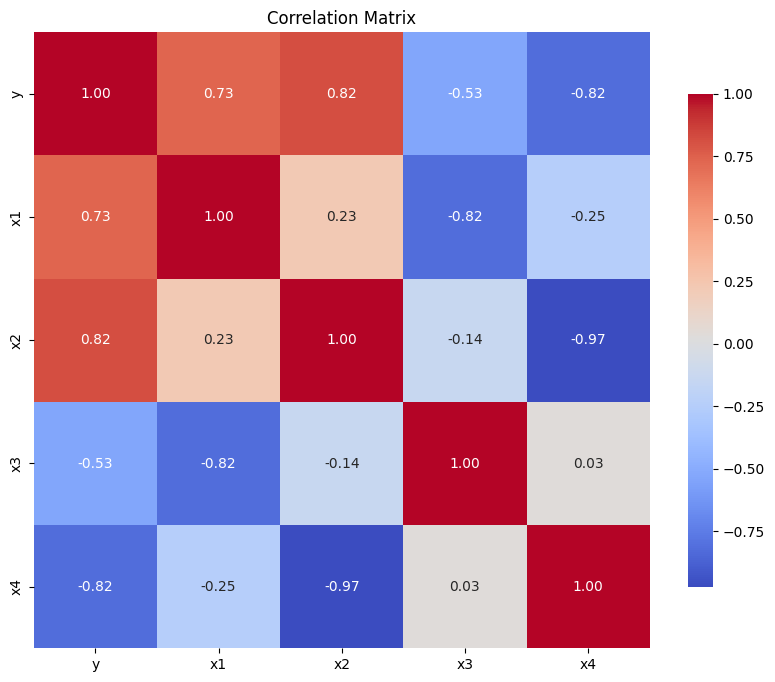

In [215]:
#matrix of corellation
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

The regressor most highly correlated with y is x4, x2

In [216]:
def forward_selection_with_t(data, response, t_cutoff):
    """
    Perform forward stepwise selection using a t-statistic cutoff value.

    Parameters:
    - data: DataFrame containing predictors and response variable.
    - response: Name of the response variable column.
    - t_cutoff: Threshold for the t-statistic to include a variable.

    Returns:
    - List of selected variables.
    """
    remaining = list(data.columns)
    remaining.remove(response)
    selected = []
    step = 1
    y = data[response]

    print(f"Stepwise Regression: {response} versus", ", ".join(remaining))
    print(f"Forward selection. T-statistic cutoff: {t_cutoff}")

    while True:
        best_tval = 0
        best_candidate = None
        best_model = None

        for candidate in remaining:
            X = sm.add_constant(data[selected + [candidate]])
            model = sm.OLS(y, X).fit()
            tval = abs(model.tvalues[candidate])

            if tval > best_tval:
                best_tval = tval
                best_candidate = candidate
                best_model = model

        if best_tval >= t_cutoff:
            selected.append(best_candidate)
            remaining.remove(best_candidate)

            print(f"\nStep {step}: Add {best_candidate}")
            print(f"{'Variable':<10}{'Coef':>10}{'T-Value':>12}{'P-Value':>12}")
            for var in best_model.params.index:
                if var == 'const':
                    name = 'Constant'
                else:
                    name = var
                print(f"{name:<10}{best_model.params[var]:>10.3f}{best_model.tvalues[var]:>12.2f}{best_model.pvalues[var]:>12.3f}")

            print(f"S = {best_model.mse_resid ** 0.5:.2f}")
            print(f"R-Sq = {best_model.rsquared * 100:.2f}")
            print(f"R-Sq(adj) = {best_model.rsquared_adj * 100:.2f}")
            SSE_p = best_model.ssr
            n = len(y)
            MSE_full = best_model.mse_resid
            p = len(selected)+1
            print(f"Mallows Cp = {((SSE_p / MSE_full) + 2 * p - n):.1f}")

            step += 1
        else:
            break

    return selected

# Example usage
selected_vars = forward_selection_with_t(df, response='y', t_cutoff=1.21)
print("\nSelected variables:", selected_vars)

Stepwise Regression: y versus x1, x2, x3, x4
Forward selection. T-statistic cutoff: 1.21

Step 1: Add x4
Variable        Coef     T-Value     P-Value
Constant     117.568       22.34       0.000
x4            -0.738       -4.77       0.001
S = 8.96
R-Sq = 67.45
R-Sq(adj) = 64.50
Mallows Cp = 2.0

Step 2: Add x1
Variable        Coef     T-Value     P-Value
Constant     103.097       48.54       0.000
x4            -0.614      -12.62       0.000
x1             1.440       10.40       0.000
S = 2.73
R-Sq = 97.25
R-Sq(adj) = 96.70
Mallows Cp = 3.0

Step 3: Add x2
Variable        Coef     T-Value     P-Value
Constant      71.648        5.07       0.001
x4            -0.237       -1.37       0.205
x1             1.452       12.41       0.000
x2             0.416        2.24       0.052
S = 2.31
R-Sq = 98.23
R-Sq(adj) = 97.64
Mallows Cp = 4.0

Selected variables: ['x4', 'x1', 'x2']


In [217]:
#Backward stepwise
def print_model_step(step, model):
    print(f"\nStep {step}")
    print(f"{'Variable':<10}{'Coef':>10}{'T-Value':>12}{'P-Value':>12}")
    for var in model.params.index:
        print(f"{var:<10}{model.params[var]:>10.3f}{model.tvalues[var]:>12.2f}{model.pvalues[var]:>12.3f}")
    print(f"\nS = {model.mse_resid ** 0.5:.2f}")
    print(f"R-Sq = {model.rsquared * 100:.2f}")
    print(f"R-Sq(adj) = {model.rsquared_adj * 100:.2f}")
    SSE_p = model.ssr
    n = len(model.model.endog)
    MSE_full = model.mse_resid
    p = len(model.params)
    print(f"Mallows Cp = {((SSE_p / MSE_full) + 2 * p - n):.1f}")

def backward_elimination(data, response, alpha_exit):
    selected = list(data.columns)
    selected.remove(response)
    y = data[response]
    step = 1

    print(f"Stepwise Regression: {response} versus {', '.join(selected)}")
    print(f"Backward elimination. Alpha-to-remove: {alpha_exit}")
    print(f"Response is {response} on {len(selected)} predictors, with N = {len(data)}")

    while True:
        X = sm.add_constant(data[selected])
        model = sm.OLS(y, X).fit()
        print_model_step(step, model)
        step += 1

        pvals = model.pvalues.drop('const')
        worst_p = pvals.max()
        worst_var = pvals.idxmax()

        if worst_p > alpha_exit:
            print(f"\nRemoving {worst_var} (p = {worst_p:.3f})")
            selected.remove(worst_var)
        else:
            print("\nNo more variables to remove. Final model:")
            break

    final_X = sm.add_constant(data[selected])
    final_model = sm.OLS(y, final_X).fit()
    print_model_step("Final", final_model)
    return selected
selected_vars1 = backward_elimination(df, response='y', alpha_exit=0.1)
print("\nSelected variables:", selected_vars1)

Stepwise Regression: y versus x1, x2, x3, x4
Backward elimination. Alpha-to-remove: 0.1
Response is y on 4 predictors, with N = 13

Step 1
Variable        Coef     T-Value     P-Value
const         62.405        0.89       0.399
x1             1.551        2.08       0.071
x2             0.510        0.70       0.501
x3             0.102        0.14       0.896
x4            -0.144       -0.20       0.844

S = 2.45
R-Sq = 98.24
R-Sq(adj) = 97.36
Mallows Cp = 5.0

Removing x3 (p = 0.896)

Step 2
Variable        Coef     T-Value     P-Value
const         71.648        5.07       0.001
x1             1.452       12.41       0.000
x2             0.416        2.24       0.052
x4            -0.237       -1.37       0.205

S = 2.31
R-Sq = 98.23
R-Sq(adj) = 97.64
Mallows Cp = 4.0

Removing x4 (p = 0.205)

Step 3
Variable        Coef     T-Value     P-Value
const         52.577       23.00       0.000
x1             1.468       12.10       0.000
x2             0.662       14.44       0.000

S =

In [218]:
#Stepwise regression
def stepwise_selection(data, response, alpha_enter, alpha_exit):
    remaining = list(data.columns)
    remaining.remove(response)
    selected = []
    y = data[response]
    step = 1

    print(f"Stepwise Regression: {response} versus {', '.join(remaining)}")
    print(f"Forward selection. Alpha-to-enter: {alpha_enter}")
    print(f"Response is {response} on {len(remaining)} predictors, with N = {len(data)}")

    while True:
        changed = False

        add_pvals = []
        for candidate in remaining:
            X = sm.add_constant(data[selected + [candidate]])
            model = sm.OLS(y, X).fit()
            pval = model.pvalues[candidate]
            add_pvals.append((pval, candidate, model))

        add_pvals.sort()
        if add_pvals and add_pvals[0][0] <= alpha_enter:
            pval, best_add, best_model = add_pvals[0]
            selected.append(best_add)
            remaining.remove(best_add)
            print_model_step(step, best_model)
            step += 1
            changed = True

        while selected:
            X = sm.add_constant(data[selected])
            model = sm.OLS(y, X).fit()
            pvals = model.pvalues.drop('const')
            worst_p = pvals.max()
            worst_var = pvals.idxmax()

            if worst_p > alpha_exit:
                print(f"\nStep {step}: Removing {worst_var} (p = {worst_p:.3f})")
                selected.remove(worst_var)
                remaining.append(worst_var)
                X = sm.add_constant(data[selected])
                model = sm.OLS(y, X).fit()
                print_model_step(step, model)
                step += 1
                changed = True
            else:
                break

        if not changed:
            print("\nNo more variables meet the entry/removal criteria. Final model:")
            break

    X = sm.add_constant(data[selected])
    final_model = sm.OLS(y, X).fit()
    print_model_step("Final", final_model)
    return selected
selected = stepwise_selection(df, response='y', alpha_enter=0.15, alpha_exit=0.15)
print("\nSelected variables:", selected)

Stepwise Regression: y versus x1, x2, x3, x4
Forward selection. Alpha-to-enter: 0.15
Response is y on 4 predictors, with N = 13

Step 1
Variable        Coef     T-Value     P-Value
const        117.568       22.34       0.000
x4            -0.738       -4.77       0.001

S = 8.96
R-Sq = 67.45
R-Sq(adj) = 64.50
Mallows Cp = 2.0

Step 2
Variable        Coef     T-Value     P-Value
const        103.097       48.54       0.000
x4            -0.614      -12.62       0.000
x1             1.440       10.40       0.000

S = 2.73
R-Sq = 97.25
R-Sq(adj) = 96.70
Mallows Cp = 3.0

Step 3
Variable        Coef     T-Value     P-Value
const         71.648        5.07       0.001
x4            -0.237       -1.37       0.205
x1             1.452       12.41       0.000
x2             0.416        2.24       0.052

S = 2.31
R-Sq = 98.23
R-Sq(adj) = 97.64
Mallows Cp = 4.0

Step 4: Removing x4 (p = 0.205)

Step 4
Variable        Coef     T-Value     P-Value
const         52.577       23.00       0.000
x1 

Forward selection: x1 x2 x4
Backward elimination: x1 x2
Stepwise regression: x1 x2